In [1]:
import itertools
from pathlib import Path

import minisom
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import shapely

from plotly.colors import sample_colorscale, make_colorscale, DEFAULT_PLOTLY_COLORS
from plotly.subplots import make_subplots
from plotly.figure_factory import create_dendrogram
from scipy.cluster import hierarchy
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from IPython.display import IFrame, Image, HTML, display_html

# Parameters

In [ ]:

data_path = Path(r'data.csv')
input_columns = ['pH', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'Cl', 'SO4']
# Columns to include in feature/component plots (can include extra columns not used for training)
feature_plot_columns = input_columns.copy()
# Example:
# feature_plot_columns = input_columns + ['CO3', 'CH4']

som_nx = None  # Set to None to determine these automatically (PCA)
som_ny = None
som_sigma = 1.5
som_learning_rate = 0.7
som_activation_distance = 'euclidean'
som_topology = 'hexagonal'
som_neighborhood_function = 'gaussian'
som_random_seed = 10
som_max_iterations = 3000

run_nbclust = False
max_clusters = 10
number_of_clusters = None  # Set to None to pick the optimal number automatically

# Visualization
# features_colorscale = 'spectral'
features_colorscale = 'RdBu'
pio.templates.default = 'plotly_white'
plotly_interactive = False

# Fixed colorscales
force_feature_colorscale_to_01 = True
specialized_colorscales = {
    "Mg": "YlGnBu",
    "Na": make_colorscale(
        ["rgb(255, 0, 0)", "rgb(0, 255, 0)", "rgb(0, 0, 255)"],
        [               0,              0.3,              1.0],
    )
}

In [3]:
# Convenience function to allow changing between interactive and static images
# Needed to show figures on GitHub notebook preview
def show_figure(fig: go.Figure):
    global fig_count
    if plotly_interactive:
        return fig
    else:
        return Image(data=fig.to_image(format='png', scale=2))


In [4]:
# Read input data
df = pd.read_csv(data_path)
df.describe()

,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
count,102.0,102.0,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.000000
mean,0.6,30.0,7.680392,7.710784,12.067647,18.490196,2.057843,10.184314,0.0,8.826471,17.335294,2627.794118
std,0.0,0.0,0.214356,6.420371,6.753762,11.158325,1.243553,3.368454,0.0,10.335902,12.658083,1313.058242
min,0.6,30.0,6.300000,0.400000,1.200000,0.200000,0.000000,2.500000,0.0,1.000000,2.000000,856.000000
25%,0.6,30.0,7.600000,3.650000,8.000000,11.825000,1.300000,8.500000,0.0,4.400000,9.025000,1902.000000
50%,0.6,30.0,7.700000,6.600000,11.300000,16.050000,1.800000,10.350000,0.0,7.300000,13.800000,2452.000000
75%,0.6,30.0,7.800000,9.550000,15.000000,21.950000,2.400000,12.775000,0.0,9.750000,23.500000,2981.000000
max,0.6,30.0,8.400000,42.600000,58.400000,81.300000,9.000000,16.800000,0.0,78.000000,66.300000,9629.000000


In [5]:
df

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
0,sample1,K-1,red,o,0.6,30,7.5,3.2,7.1,11.5,1.3,14.8,0,2.2,3.5,1483
1,sample2,K-1,red,o,0.6,30,7.7,2.6,7.0,13.0,1.4,13.3,0,3.8,3.2,1601
2,sample3,K-1,red,o,0.6,30,7.3,1.2,8.0,12.0,1.3,13.9,0,2.0,3.4,1542
3,sample4,K-1,red,o,0.6,30,7.4,2.2,6.6,12.6,1.4,13.6,0,2.4,3.1,1518
4,sample5,K-1,red,o,0.6,30,7.3,2.5,9.6,10.3,1.1,14.3,0,2.0,3.4,1476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,sample98,P-7,orange,o,0.6,30,7.9,1.8,2.4,3.8,0.4,4.0,0,1.0,3.4,856
98,sample99,P-8,cyan,o,0.6,30,7.5,12.2,14.0,8.6,1.0,5.5,0,6.0,23.4,2394
99,sample100,P-8,cyan,o,0.6,30,7.8,12.8,13.4,9.6,1.1,6.3,0,6.0,23.8,2456
100,sample101,P-8,cyan,o,0.6,30,7.8,11.6,12.0,11.4,1.3,5.2,0,6.2,23.8,2435


In [6]:
# Apply data transformation

# Normalization:
def apply_normalization(arr):
    data_min = arr.min(axis=0)
    data_range = arr.max(axis=0) - data_min
    return (arr - data_min) / data_range

# Standardization
def apply_standardization(arr):
    data_mean = arr.mean(axis=0)
    data_std = arr.std(axis=0)
    return (arr - data_mean) / data_std

# Sigmoid
def apply_sigmoid(arr):
    return 1 / (1 + np.exp(-arr))

input_array = df[input_columns].values

## Uncomment the appropriate transform
# transformed_data = apply_normalization(input_array)
# transformed_data = apply_standardization(input_array)
transformed_data = apply_sigmoid(input_array)

# SOM model

In [7]:
# Derive SOM dimensions
if som_nx is None or som_ny is None:
    recommended_nodes = 5 * np.sqrt(len(df))

    # "Naive" approach: square root of the number of samples (with round-off)
    # final_nx = np.round(np.sqrt(som_m)).astype(int)
    # final_ny = np.round(som_m / som_nx).astype(int)

    # Perform PCA analysis
    pca = PCA(n_components=2)
    pca.fit(transformed_data)

    # Calculate the ratio between the first two principal components
    pca_ratio = pca.explained_variance_[0] / pca.explained_variance_[1]
    final_nx = np.round(np.sqrt(recommended_nodes * pca_ratio)).astype(int)
    final_ny = np.round(recommended_nodes / final_nx).astype(int)
    print(f"Using PCA to determine SOM dimensions: {final_nx} x {final_ny} (PCA ratio: {pca_ratio:.2f})")
else:
    final_nx, final_ny = som_nx, som_ny
    print(f"Using fixed SOM dimensions: {final_nx} x {final_ny}")

Using PCA to determine SOM dimensions: 10 x 5 (PCA ratio: 1.87)


In [8]:

# Set up model
som = minisom.MiniSom(
    final_nx,
    final_ny,
    len(input_columns),
    sigma=som_sigma,
    learning_rate=som_learning_rate,
    activation_distance=som_activation_distance,
    topology=som_topology,
    neighborhood_function=som_neighborhood_function,
    random_seed=som_random_seed,
)

# Train
som.train(transformed_data, som_max_iterations)

# Extract data
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()
win_map = som.win_map(transformed_data, return_indices=True)

In [9]:
# Print quantization and topographic errors for the trained model
print(f"Quantization error: {som.quantization_error(transformed_data)}")
print(f"Topographic error : {som.topographic_error(transformed_data)}")


Quantization error: 0.018069447758917796
Topographic error : 0.11764705882352944


In [10]:
# Setup input to clustering and dendrogram plot
mij = np.meshgrid(np.arange(final_nx), np.arange(final_ny), indexing='ij')
cells_ij = np.column_stack((mij[0].flat, mij[1].flat))
labels = [(i, j) for i, j in cells_ij]
flat_weights = weights.reshape(-1, len(input_columns)) 

links = hierarchy.linkage(flat_weights, method='complete', metric='euclidean')


# Clustering

In [11]:
if run_nbclust:
    # For this to work, the R_HOME environment variable needs to be set to the R installation directory
    # e.g. C:\Program Files\R\R-4.0.3

    from rpy2.robjects.packages import importr
    from rpy2.robjects import numpy2ri

    # Activate automatic conversion between numpy and R arrays
    numpy2ri.activate()

    # Import required R packages
    base = importr('base')
    stats = importr('stats')
    NbClust = importr('NbClust')

    # Run NbClust
    # See https://www.rdocumentation.org/packages/NbClust/versions/3.0.1/topics/NbClust
    # This will determine the optimal number of clusters using multiple indices
    nb_results = NbClust.NbClust(
        data=flat_weights,
        distance="euclidean",
        min_nc=2,
        max_nc=10,
        method="complete",
        index="all"
    )

    nbclust_lables = np.array(nb_results.rx2('Best.partition'))

In [12]:
cluster_results = []

for i in range(2, max_clusters):
    flat_labels = hierarchy.fcluster(links, i, 'maxclust')
    dbi = davies_bouldin_score(flat_weights, flat_labels) if len(set(flat_labels)) == i else None
    sil = silhouette_score(flat_weights, flat_labels) if len(set(flat_labels)) == i else None
    cluster_results.append({
        "Number of clusters": i,
        "DBI": dbi,
        "Silhouette": sil,
        "labels": flat_labels,
    })

cluster_df = pd.DataFrame.from_dict(cluster_results)

dbi_optimal_cluster = cluster_df.iloc[cluster_df['DBI'].idxmin()]
sil_optimal_cluster = cluster_df.iloc[cluster_df['Silhouette'].idxmax()]

if number_of_clusters is None:
    selected_cluster = dbi_optimal_cluster
else:
    selected_cluster = cluster_df[cluster_df['Number of clusters'] == number_of_clusters].iloc[0]

In [13]:
print(f"Optimal number of clusters based on DBI        : {dbi_optimal_cluster['Number of clusters']}")
print(f"Optimal number of clusters based on Silhouette : {sil_optimal_cluster['Number of clusters']}")
print()

if number_of_clusters is None:
    print(f"Number of clusters picked based on DBI         : {selected_cluster['Number of clusters']}")
else:
    print(f"Number of clusters fixed to                    : {number_of_clusters}")

Optimal number of clusters based on DBI        : 5
Optimal number of clusters based on Silhouette : 2

Number of clusters picked based on DBI         : 5


In [14]:
fig = px.line(cluster_df, x='Number of clusters', y='DBI', markers=True)
fig.layout.title = "Davies-Bouldin Index (lower is better)"
fig.layout.yaxis.spikesnap = "hovered data"
fig.layout.yaxis.spikemode = "across"
fig.layout.yaxis.spikethickness = 1
fig

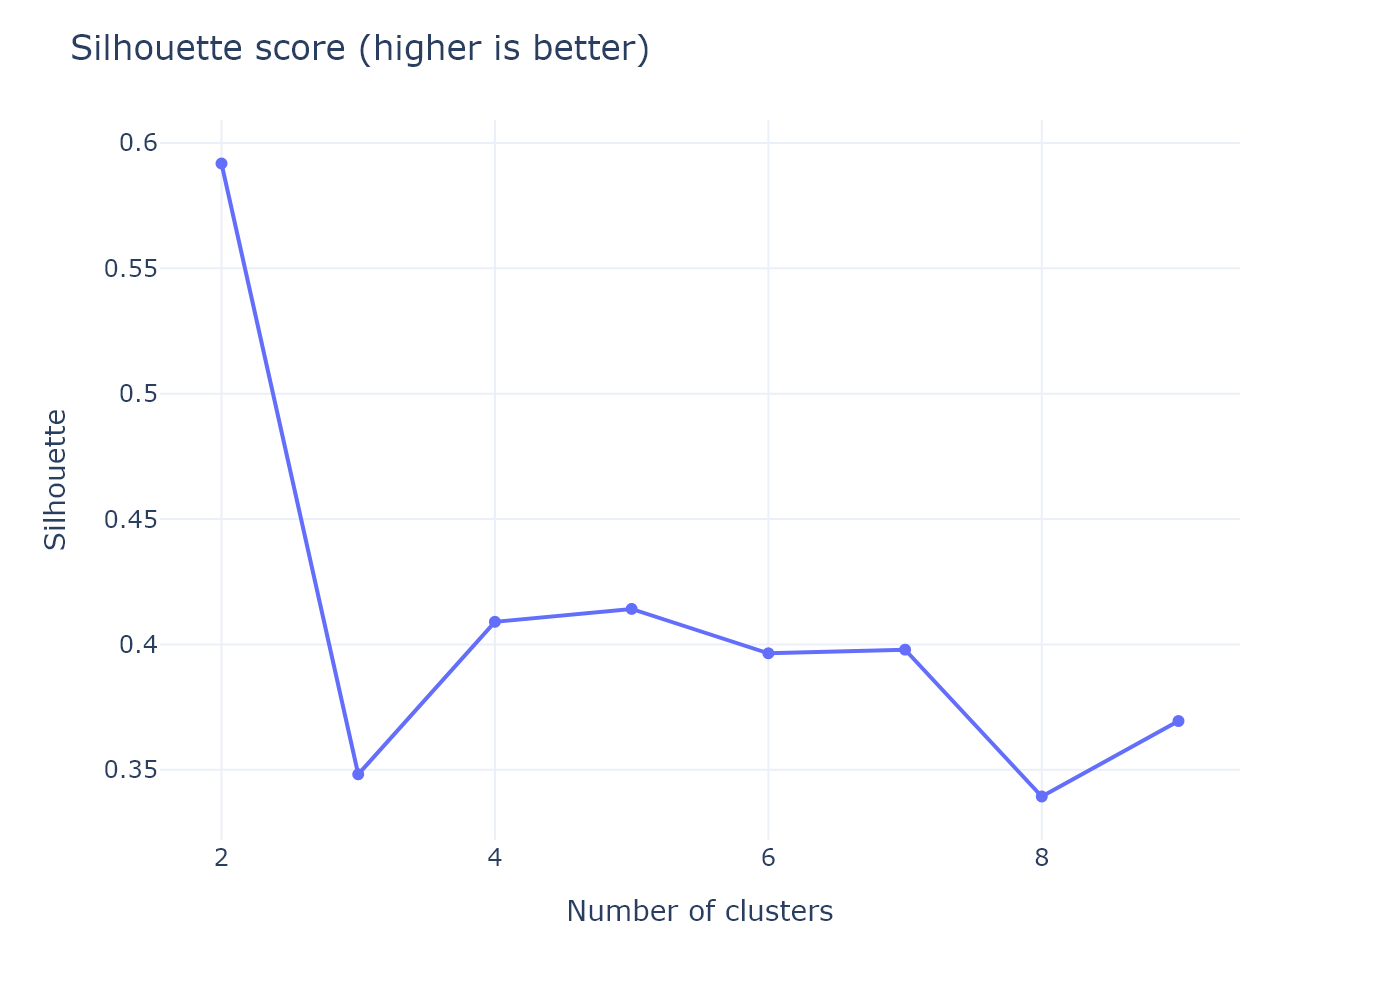

In [15]:
fig = px.line(cluster_df, x='Number of clusters', y='Silhouette', markers=True)
fig.layout.title = "Silhouette score (higher is better)"
fig.layout.yaxis.spikesnap = "hovered data"
fig.layout.yaxis.spikemode = "across"
fig.layout.yaxis.spikethickness = 1
show_figure(fig)

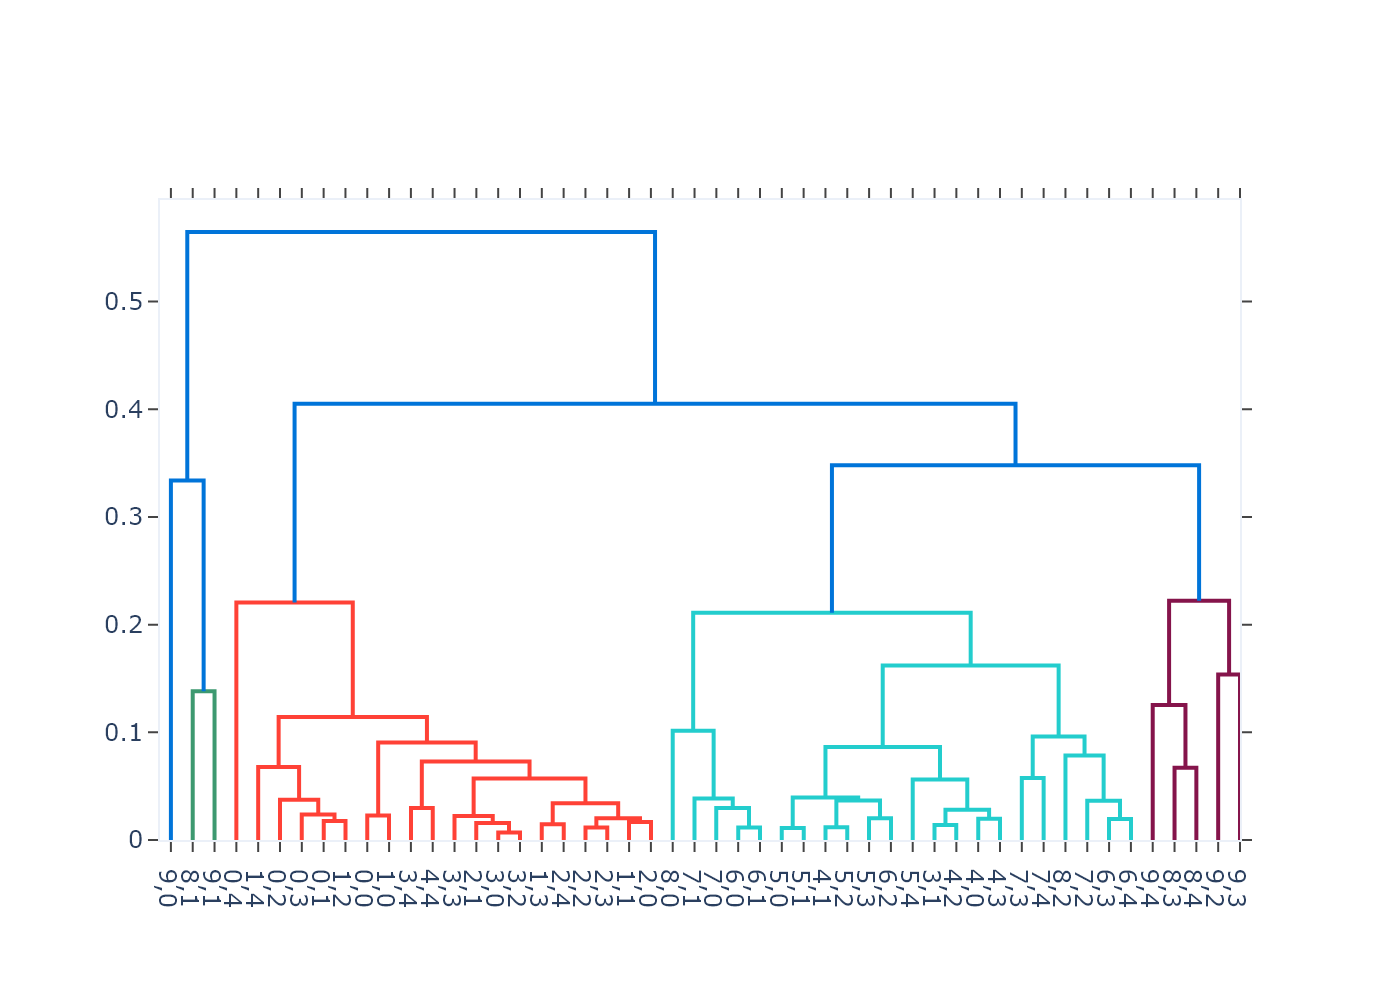

In [16]:
show_figure(create_dendrogram(
    flat_weights,
    linkagefun=lambda _: links,
    labels=labels,
    # NB! The color_threshold must be manually set to a value corresponding to the number of clusters
    color_threshold=0.3
))

In [17]:
# Optimal number of lables
node_labels = selected_cluster['labels'].reshape(final_nx, final_ny)

# Sample labels
sample_ij = [None] * len(df)
sample_label = [-1] * len(df)
for key, value in win_map.items():
    for ix in value:
        sample_ij[ix] = key
        sample_label[ix] = node_labels[key]

df['ij'] = sample_ij
df['cluster_label'] = sample_label


In [18]:
n_cols = 6
for lab, sub_df in df.groupby('cluster_label'):
    print(f"Cluster {lab}: {len(sub_df)} samples")
    for i, s in enumerate(sub_df['Sample']):
        print(f"  {s:19}", end="")
        if i % n_cols == n_cols - 1:
            print()
    print("\n")

Cluster 1: 2 samples
  sample96             sample98           

Cluster 2: 1 samples
  sample97           

Cluster 3: 45 samples
  sample12             sample13             sample14             sample15             sample23             sample25           
  sample27             sample28             sample29             sample30             sample37             sample38           
  sample39             sample41             sample43             sample44             sample45             sample46           
  sample47             sample54             sample58             sample60             sample64             sample65           
  sample68             sample69             sample70             sample71             sample72             sample73           
  sample74             sample75             sample76             sample77             sample78             sample82           
  sample83             sample84             sample85             sample86             sample88             

In [19]:
t = ""
for lab, sub in df.groupby('cluster_label'):
    t += f"<h2>Cluster {lab}</h2>"
    t += " ".join(sub["Sample"])
    t += sub.describe().to_html()
display_html(t, raw=True)

,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS,cluster_label
count,2.0,2.0,2.000000,2.000000,2.000000,2.000000,2.0,2.000000,2.0,2.000000,2.0,2.000000,2.0
mean,0.6,30.0,7.700000,2.800000,2.900000,3.500000,0.4,4.800000,0.0,1.400000,3.4,925.500000,1.0
std,0.0,0.0,0.282843,1.414214,0.707107,0.424264,0.0,1.131371,0.0,0.565685,0.0,98.287843,0.0
min,0.6,30.0,7.500000,1.800000,2.400000,3.200000,0.4,4.000000,0.0,1.000000,3.4,856.000000,1.0
25%,0.6,30.0,7.600000,2.300000,2.650000,3.350000,0.4,4.400000,0.0,1.200000,3.4,890.750000,1.0
50%,0.6,30.0,7.700000,2.800000,2.900000,3.500000,0.4,4.800000,0.0,1.400000,3.4,925.500000,1.0
75%,0.6,30.0,7.800000,3.300000,3.150000,3.650000,0.4,5.200000,0.0,1.600000,3.4,960.250000,1.0
max,0.6,30.0,7.900000,3.800000,3.400000,3.800000,0.4,5.600000,0.0,1.800000,3.4,995.000000,1.0
,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS,cluster_label
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Plotting and Visualization

In [20]:
# Create hexagons for visualization
def hexagon(_xx, _yy, radius):
    # Returns a NX x NY x 6 x 2 array of hexagon coordinates
    hex_xy = np.zeros((_xx.shape[0], _xx.shape[1], 7, 2))
    for i in range(7):
        theta = np.pi / 6 + 2 * np.pi * i / 6
        hex_xy[:, :, i, 0] = _xx + radius * np.cos(theta)
        hex_xy[:, :, i, 1] = _yy + radius * np.sin(theta)
    return hex_xy


hexagons = hexagon(xx, yy, 0.5)
hexagons.shape

(10, 5, 7, 2)

In [21]:

# Cluster polygons
node_hexagons = hexagon(xx, yy, np.sqrt(3) / 3 + 0.001).reshape(-1, 7, 2)
cluster_boundaries = {}
for c in np.unique(node_labels):
    matches = node_labels.flatten() == c
    joined_polygon = shapely.union_all([shapely.Polygon(p) for p in node_hexagons[matches]])
    cluster_boundaries[c] = joined_polygon

In [ ]:
# Define functions for plotting
def add_cluster_boundaries(fig: go.Figure, row_index, col_index):
    for k, boundary in cluster_boundaries.items():
        
        if boundary.geom_type == 'Polygon':
            bnds = [boundary]
        elif boundary.geom_type == 'MultiPolygon':
            bnds = list(boundary.geoms)
        else:
            raise NotImplementedError(boundary.geom_type)
        
        for poly in bnds:
            if poly.boundary.geom_type == 'LineString':
                crds = np.array(poly.boundary.coords)
            else:
                crds = np.array(poly.boundary.geoms[0].coords)

            fig.add_scatter(
                x=crds[:, 0],
                y=crds[:, 1],
                # fill='toself',
                mode="lines",
                showlegend=False,
                line=dict(color='black', width=2),
                row=row_index,
                col=col_index,
            )


def add_som_grid(fig: go.Figure, row, col, w_in, colorbar_settings, colorscale):
    # Accepts an arbitrary grid (final_nx x final_ny), normalizes and plots it on the SOM hex grid
    w = np.array(w_in, dtype=float).copy()
    nan_mask = np.isnan(w)

    if force_feature_colorscale_to_01:
        w_min = 0
        w_max = 1
    else:
        # Use nan-aware mins and maxes
        if np.all(nan_mask):
            w_min = 0
            w_max = 1
        else:
            w_min = float(np.nanmin(w))
            w_max = float(np.nanmax(w))

    # Normalize to [0,1] for color sampling
    if np.all(nan_mask):
        w_norm = np.zeros_like(w)
    else:
        mn = float(np.nanmin(w))
        mx = float(np.nanmax(w))
        if mx > mn:
            w_norm = (w - mn) / (mx - mn)
        else:
            w_norm = np.zeros_like(w)

    colors = np.array(
        sample_colorscale(colorscale, np.nan_to_num(w_norm, nan=0.0).flatten())
    ).reshape(final_nx, final_ny)

    # Add colored hexagons
    for i in range(final_nx):
        for j in range(final_ny):
            text = str(sorted(df.iloc[win_map[(i, j)]].index.values.tolist()))
            fillcolor = 'rgba(0,0,0,0)' if nan_mask[i, j] else colors[i, j]

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=fillcolor,
                line=dict(color='black', width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )
           
    fig.add_scatter(
        x=[0, 0],
        y=[0, 0],
        showlegend=False,
        marker=dict(color=[w_min, w_max], colorscale=colorscale, size=0.001, colorbar=colorbar_settings),
        row=row,
        col=col,
    )


def add_som_features(fig: go.Figure, row, col, feature_index, colorbar_settings, colorscale):
    # Backwards-compatible wrapper using trained SOM weights or Umatrix
    if feature_index >= weights.shape[2]:
        w = umatrix.copy()
    else:
        # The value of the weights will refer to the transformed data. If we want
        # the original scale, we will need to apply the inverse transform here
        w = weights[:, :, feature_index]
    add_som_grid(fig, row, col, w, colorbar_settings, colorscale)


def add_training_cells(fig: go.Figure, row, col):
    # Add colored hexagons
    label_colors = DEFAULT_PLOTLY_COLORS
    for i in range(final_nx):
        for j in range(final_ny):
            text = ""
            if len(win_map[(i, j)]) > 0:
                samples = [str(s) for s in sorted(df.iloc[win_map[(i, j)]].index.values.tolist())]
                if len(samples) <= 3:
                    text = f"{','.join(samples)}"
                elif len(samples) <= 6:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:])}"
                elif len(samples) <= 9:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:6])}" + f"<br>{','.join(samples[6:])}"
                else:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:-3])}" + f"<br>{','.join(samples[-3:])}"

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=label_colors[node_labels[i, j]],
                line=dict(width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )

            mid = (hexagons[i, j, 0, :] + hexagons[i, j, 3, :]) / 2
            fig.add_scatter(
                x=[mid[0]],
                y=[mid[1]],
                mode="text",
                text=text,
                textfont=dict(color="black", size=6),
                marker=dict(color='black'),
                showlegend=False,
                hoverinfo="none",
                row=row,
                col=col,
            )


n_plots = len(feature_plot_columns) + 2
subplot_rows = (n_plots + 1) // 2
subplot_columns = 2
vertical_spacing = 0.1
features_fig = make_subplots(
    rows=subplot_rows,
    cols=subplot_columns,
    subplot_titles=feature_plot_columns + ["Umatrix"] + ["Clusters and winning cells"],
    horizontal_spacing=0.15,
    vertical_spacing=vertical_spacing,

)
features_fig.layout.height = 50 + 250 * subplot_rows
v_margin = int(vertical_spacing * features_fig.layout.height)
features_fig.layout.margin = dict(l=0, r=0, t=v_margin, b=v_margin)

subplot_ix = list(
    itertools.product(range(1, subplot_rows + 1), range(1, subplot_columns + 1))
)[:n_plots]

# Feature plots (trained inputs + any additional columns)
for i, (row_index, col_index) in enumerate(subplot_ix[:len(feature_plot_columns)]):
    # add_cluster_boundaries(features_fig, row_index, col_index)
    colorbar_settings = dict(
        orientation = "h",
        thickness = 20,
        len = 0.35,
        y = -0.5 * vertical_spacing + (1 + vertical_spacing) * (1 - row_index / subplot_rows),
        x = 0.2 if col_index == 1 else 0.8
    )

    col_name = feature_plot_columns[i]
    cs = specialized_colorscales.get(col_name, features_colorscale)

    if col_name in input_columns:
        feat_idx = input_columns.index(col_name)
        w = weights[:, :, feat_idx]
    else:
        # Compute per-cell mean of the selected column
        w = np.full((final_nx, final_ny), np.nan, dtype=float)
        for (ii, jj), idxs in win_map.items():
            if len(idxs) == 0:
                w[ii, jj] = np.nan
            else:
                vals = pd.to_numeric(df.loc[idxs, col_name], errors='coerce').values
                w[ii, jj] = np.nanmean(vals)

    add_som_grid(features_fig, row_index, col_index, w, colorbar_settings, cs)

# Umatrix plot in the next slot
um_row, um_col = subplot_ix[len(feature_plot_columns)]
um_colorbar = dict(
    orientation = "h",
    thickness = 20,
    len = 0.35,
    y = -0.5 * vertical_spacing + (1 + vertical_spacing) * (1 - um_row / subplot_rows),
    x = 0.2 if um_col == 1 else 0.8
)
add_som_grid(features_fig, um_row, um_col, umatrix.copy(), um_colorbar, features_colorscale)

features_fig.update_traces(dict(marker=dict(colorbar=dict(orientation="h"))))

add_training_cells(features_fig, subplot_ix[-1][0], subplot_ix[-1][1])
add_cluster_boundaries(features_fig, subplot_ix[-1][0], subplot_ix[-1][1])


for i, (row_index, col_index) in enumerate(subplot_ix):
    sp = features_fig.get_subplot(row_index, col_index)
    sp.yaxis.scaleanchor = sp.yaxis.anchor
    sp.yaxis.showticklabels = False
    sp.xaxis.showticklabels = False


show_figure(features_fig)

# Gibbs diagram

In [ ]:
# Values from https://github.com/jyangfsu/WQChartPy/blob/main/wqchartpy/gibbs.py
na_ca_line = np.array(
    [
        [0.0083, 0.0277, 0.0505, 0.0668, 0.0830, 0.1090, 0.1253, 0.1481, 0.1611, 0.1871, 0.2067, 0.2294, 0.2457, 0.2718, 0.2880, 0.3174, 0.3500, 0.3956, 0.4379, 0.4802, 0.5225, 0.5681, 0.6039, 0.6429, 0.6819, 0.7144, 0.7534, 0.7729, 0.7924, 0.8119, 0.8314, 0.8509, 0.8737, 0.8997, 0.9225, 0.9420, 0.9615, 0.9843, 0.9973, None, None, 0.9932, 0.9866, 0.9636, 0.9406, 0.9209, 0.9045, 0.8881, 0.8716, 0.8519, 0.8322, 0.8026, 0.7663, 0.7367, 0.7070, 0.6774, 0.6543, 0.6279, 0.6146, 0.5916, 0.5783, 0.5617, 0.5419, 0.5383, 0.5513, 0.5739, 0.6096, 0.6453, 0.6778, 0.6940, 0.7135, 0.7362, 0.7653, 0.8010, 0.8399, 0.8724, 0.8983, 0.9340, 0.9469, 0.9696, 0.9891, 0.9955, None, None, 0.9003, 0.8871, 0.8410, 0.8278, 0.7949, 0.7619, 0.7290, 0.6830, 0.6369, 0.5942, 0.5516, 0.5089, 0.4399, 0.4005, 0.3545, 0.3118, 0.2658, 0.2296, 0.1836, 0.1442, 0.1047, 0.0718, 0.0454, 0.0092],
        [108.9257, 97.0774, 88.1725, 80.1044, 74.1755, 66.0907, 61.199, 56.6553, 52.4686, 47.6497, 44.9668, 40.842, 39.2892, 35.6808, 33.0399, 30.5792, 28.2983, 24.7192, 21.5954, 18.5101, 15.5659, 12.5986, 11.0093, 9.0844, 7.3545, 6.3061, 5.2036, 4.6375, 4.2938, 3.8267, 3.543, 3.2184, 2.9232, 2.6046, 2.321, 2.1489, 1.9896, 1.8419, 1.7386, 1.7386, 7514.32, 7514.32, 7234.9489, 6582.7621, 5989.366, 5553.6776, 5051.7878, 4683.7185, 4179.9779, 3730.8803, 3394.141, 2808.0488, 2153.0926, 1714.648, 1365.4861, 1087.4256, 899.4273, 702.6564, 592.1454, 508.812, 420.6893, 334.8554, 271.6992, 204.138, 175.1691, 144.6326, 114.8937, 91.2695, 78.2591, 68.4377, 59.8414, 50.3607, 39.2599, 30.5983, 22.9525, 18.2353, 14.4912, 11.7332, 10.262, 8.6362, 7.5514, 7.267, 7.267, 45278.8769, 45278.8769, 39640.8983, 28715.7533, 25624.1396, 20408.7169, 15947.8034, 12461.9512, 9558.8684, 7473.2267, 6069.0146, 5023.5351, 4238.2048, 3072.823, 2592.1249, 2065.5649, 1614.6797, 1311.4464, 1044.6506, 816.7192, 650.65, 508.5584, 412.8464, 341.5145, 261.8588],
    ]
)
cl_hco3_line = np.array(
    [
        [0.0056, 0.0251, 0.0446, 0.0771, 0.1096, 0.1291, 0.1454, 0.1844, 0.2104, 0.2299, 0.2656, 0.2883, 0.3078, 0.3500, 0.3792, 0.4052, 0.4507, 0.4799, 0.4994, 0.5351, 0.5579, 0.5741, 0.5904, 0.6196, 0.6488, 0.6716, 0.6976, 0.7236, 0.7495, 0.7723, 0.7983, 0.8242, 0.8535, 0.8827, 0.9119, 0.9444, 0.9704, 0.9931, None, None, 0.9961, 0.9830, 0.9668, 0.9538, 0.944, 0.9180, 0.9050, 0.8887, 0.8530, 0.8302, 0.8074, 0.7814, 0.7554, 0.7294, 0.7132, 0.6937, 0.6742, 0.6417, 0.6189, 0.5897, 0.5735, 0.5605, 0.5377, 0.5150, 0.4955, 0.4760, 0.4565, 0.4402, 0.4175, 0.4013, 0.3785, 0.3590, 0.3395, 0.3200, 0.3070, 0.2941, 0.2746, 0.2551, 0.2388, 0.2291, 0.2128, 0.2063, 0.1998, 0.1997, 0.2062, 0.2159, 0.2354, 0.2516, 0.2646, 0.2873, 0.3002, 0.3262, 0.3489, 0.3683, 0.3878, 0.4105, 0.4267, 0.4527, 0.4754, 0.5175, 0.5500, 0.5694, 0.5889, 0.6148, 0.6376, 0.6538, 0.6700, 0.6927, 0.7089, 0.7252, 0.7479, 0.7771, 0.7965, 0.8160, 0.8322, 0.8517, 0.8841, 0.9003, 0.9165, 0.9392, 0.9522, 0.9684, 0.9846, 0.9975, None, None, 0.9935, 0.9870, 0.9708, 0.9579, 0.9385, 0.9255, 0.9061, 0.8801, 0.8607, 0.8347, 0.8088, 0.7893, 0.7602, 0.7277, 0.6855, 0.6531, 0.6044, 0.5623, 0.5298, 0.4909, 0.4520, 0.4196, 0.3839, 0.3450, 0.3158, 0.2899, 0.2672, 0.2380, 0.2088, 0.1861, 0.1634, 0.1408, 0.1148, 0.0889, 0.0759, 0.0630, 0.0500, 0.0371, 0.0209, 0.0079],
        [21.4751, 19.1493, 17.0753, 15.2298, 13.0728, 11.8826, 11.2221, 10.2041, 9.6387, 9.2797, 8.9368, 8.7709, 8.6076, 8.6146, 8.4558, 8.2994, 7.8425, 7.6979, 7.4111, 7.0018, 6.7414, 6.4899, 6.3687, 5.9019, 5.6831, 5.4718, 5.1686, 4.9767, 4.7919, 4.6137, 4.5284, 4.4446, 4.3627, 4.2822, 4.2033, 4.2059, 4.208, 4.1299, 4.1299, 10.1674, 10.1674, 11.4037, 12.7896, 14.0724, 15.4849, 17.6996, 19.8518, 21.8417, 24.487, 27.9908, 30.2081, 33.2299, 35.8599, 38.6981, 40.9758, 43.3849, 46.8245, 50.5243, 54.5265, 58.8385, 61.1188, 62.2861, 67.2201, 69.8165, 73.9212, 76.7813, 81.2954, 84.446, 89.4052, 92.8702, 96.4574, 102.1283, 104.0659, 110.1841, 114.4615, 116.6475, 121.1607, 125.8485, 130.7259, 138.4373, 146.5855, 161.3088, 174.141, 191.656, 219.2029, 236.7142, 260.6201, 281.4751, 298.2091, 322.1122, 347.8662, 383.045, 421.755, 455.5326, 482.6745, 521.3635, 563.0834, 608.2554, 657.0104, 751.9576, 828.1041, 877.4449, 929.7256, 985.244, 1044.0127, 1085.1491, 1127.9064, 1195.1847, 1242.2777, 1291.2262, 1368.2463, 1506.707, 1596.481, 1724.3402, 1826.9677, 1973.2861, 2258.0322, 2485.9166, 2684.8419, 3013.3769, 3317.2855, 3582.7378, 3944.3137, 4178.8072, 4178.8072, 62336.9735, 62336.9735, 56633.1044, 49506.8651, 42458.3638, 35717.6411, 33073.3075, 28909.8381, 24787.6514, 22513.9619, 20058.1172, 17870.1583, 16545.0928, 14739.4207, 13643.1016, 12151.1174, 11247.3165, 9825.9309, 8585.2422, 7795.8054, 6682.5559, 5839.1344, 5201.5485, 4459.0392, 3822.2836, 3277.0691, 2919.6032, 2551.907, 2273.401, 1875.816, 1703.6475, 1460.8193, 1252.6024, 1053.6071, 886.2253, 805.035, 731.2828, 677.1427, 603.4295, 517.4845, 452.3967],
    ]
)

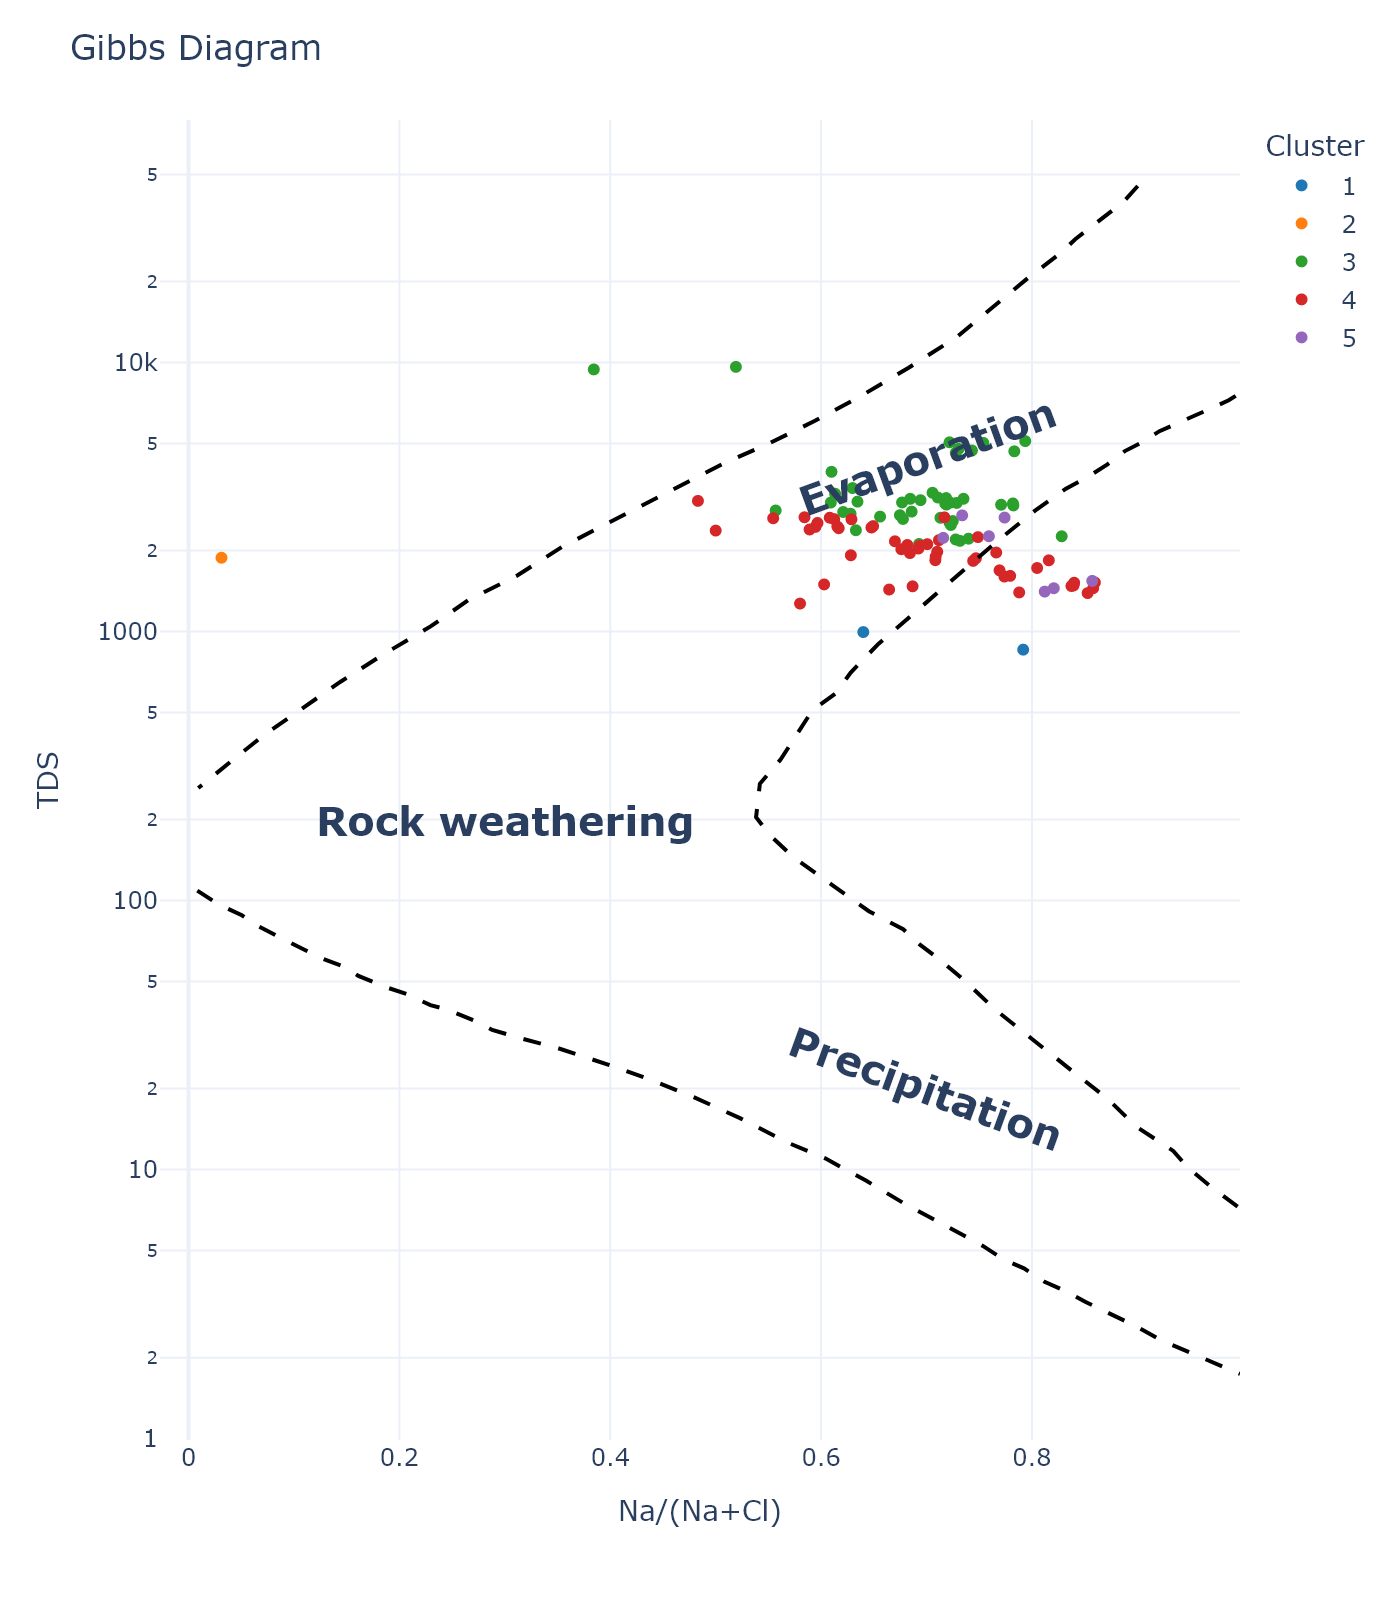

In [ ]:
# Create a figure that shows a hydrological Gibbs diagram with Na/Na+Cl on the x-axis and logarithmic TDS on the y-axis
# Calculate Na/(Na+Cl) and log(TDS)
df['Na/(Na+Cl)'] = df['Na'] / (df['Na'] + df['Cl'])
df['cluster_label_str'] = df['cluster_label'].astype(str)

# Create Gibbs diagram
fig_gibbs = px.scatter(
    df,
    x='Na/(Na+Cl)',
    y='TDS',
    log_y=True,
    color=df['cluster_label_str'],
    category_orders={'cluster_label_str': list(sorted(df['cluster_label_str'].unique()))},
    color_discrete_sequence=DEFAULT_PLOTLY_COLORS,
)
fig_gibbs.add_scatter(
    x=na_ca_line[0],
    y=na_ca_line[1],
    mode='lines',
    line=dict(color='black', width=2, dash='dash'),
    name='Na/Ca line',
    showlegend=False,
)
fig_gibbs.add_annotation(
    x=0.3,
    y=np.log10(200),
    showarrow=False,
    text="Rock weathering",
    font=dict(size=20, weight="bold"),
)
fig_gibbs.add_annotation(
    x=0.7,
    y=np.log10(4500),
    showarrow=False,
    text="Evaporation",
    font=dict(size=20, weight="bold"),
    textangle=-20,
)
fig_gibbs.add_annotation(
    x=0.7,
    y=np.log10(20),
    showarrow=False,
    text="Precipitation",
    font=dict(size=20, weight="bold"),
    textangle=20,
)

# Update layout
fig_gibbs.update_layout(
    title='Gibbs Diagram',
    xaxis_title='Na/(Na+Cl)',
    yaxis_title='TDS',
    # coloraxis_colorbar=dict(title='Cluster')
)
fig_gibbs.layout.height = 800
fig_gibbs.layout.legend.title = 'Cluster'

show_figure(fig_gibbs)


# Piper diagram

In [ ]:
# Calculate percentages for Piper diagram
sum_cations = df[['Ca', 'Mg', 'K', 'Na']].sum(axis=1)
sum_anions = df[['Cl', 'SO4', 'CO3', 'HCO3']].sum(axis=1)

df['Ca%'] = df['Ca'] / sum_cations
df['Mg%'] = df['Mg'] / sum_cations
df['K+Na%'] = (df['K'] + df['Na']) / sum_cations

df['Cl%'] = df['Cl'] / sum_anions
df['SO4%'] = df['SO4'] / sum_anions
df['CO3+HCO3%'] = (df['CO3'] + df['HCO3']) / sum_anions


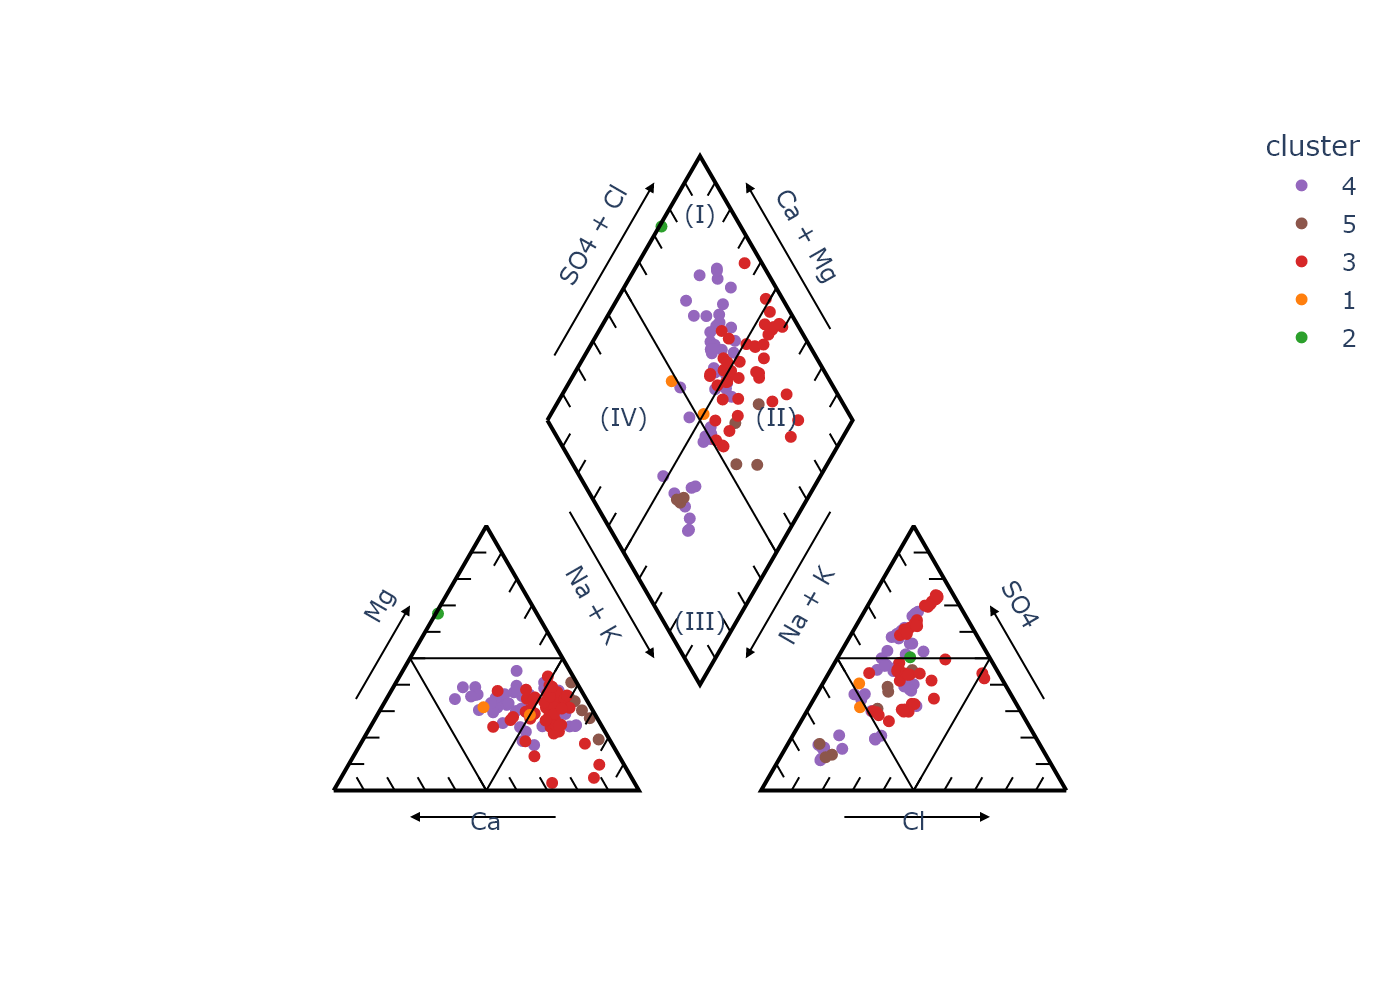

In [ ]:
# ------------------------------------------------------------
# Figure settings
# ------------------------------------------------------------

axis_length = 10
theta = np.pi/3
line_color = "black"
gap = 0.4
tick_length = 0.05
arrow_args = dict(
    axref="x",
    ayref="y",
    showarrow=True,
    arrowhead=2,
    arrowcolor=line_color,
)
arrow_txt_args = dict(
    showarrow=False,
)
outer_axis_args = dict(
    mode="lines",
    line=dict(color=line_color, width=2),
    showlegend=False,
)
inner_axis_args = dict(
    mode="lines",
    line=dict(color=line_color, width=1),
    showlegend=False,
)

diamond_u = axis_length * np.array([np.cos(-theta), np.sin(-theta)])
diamond_v = axis_length * np.array([np.cos(theta), np.sin(theta)])

lowerleft_v = diamond_v.copy()
lowerleft_u = np.array([axis_length, 0])
lowerleft_w = -diamond_u
lowerleft_o = np.zeros_like(lowerleft_v)

diamond_o = lowerleft_o + (1 + gap) * diamond_v
lowerright_o = lowerleft_o + (2 + gap)  * diamond_v + (2 + gap) * diamond_u
lowerright_u = -lowerleft_u
lowerright_v = -diamond_u
lowerright_w = lowerleft_v

ticks = np.arange(1, 10) * 0.1

# ------------------------------------------------------------
# Setup data and initial plot
# ------------------------------------------------------------

# Lower left data
data_lowerleft = (
    lowerleft_o[:, np.newaxis]
    + (1 - (df['Ca%'])).values * lowerleft_u[:, np.newaxis]
    + df['Mg%'].values * lowerleft_w[:, np.newaxis]
).T

# Lower right data
data_lowerright = (
    lowerright_o[:, np.newaxis]
    + (1 - (df['Cl%'])).values * lowerright_u[:, np.newaxis]
    + df['SO4%'].values * lowerright_w[:, np.newaxis]
).T

# Diamond data
data_diamond = (
    diamond_o[:, np.newaxis]
    + df['K+Na%'].values * diamond_u[:, np.newaxis]
    + (df['SO4%'] + df['Cl%']).values * diamond_v[:, np.newaxis]
).T

xy_data = np.vstack((data_lowerleft, data_lowerright, data_diamond))
plotting_df = pd.DataFrame(xy_data, columns=['x', 'y'])
plotting_df['cluster'] = np.hstack([df['cluster_label'].values.tolist()] * 3).astype(str)
color_map = {str(i): c for i, c in enumerate(DEFAULT_PLOTLY_COLORS)}
fig_piper = px.scatter(plotting_df, x="x", y="y", color="cluster", color_discrete_map=color_map)

# ------------------------------------------------------------
# Lower-left triangle
# ------------------------------------------------------------

ll_axis = np.array([
    lowerleft_o,
    lowerleft_o + lowerleft_v,
    lowerleft_o + lowerleft_u,
    lowerleft_o,
])
ll_tri = np.array([
    lowerleft_o + 0.5 * lowerleft_u,
    lowerleft_o + 0.5 * lowerleft_u + 0.5 * lowerleft_v,
    lowerleft_o + 0.5 * lowerleft_v,
    lowerleft_o + 0.5 * lowerleft_u,
])
# Ticks, left side
ll_tick_l0 = lowerleft_o + lowerleft_v * ticks[:, np.newaxis]
ll_tick_l1 = ll_tick_l0 + tick_length * lowerleft_u
ll_tick_left = np.full((ll_tick_l0.shape[0] * 3, 2), fill_value=np.nan)
ll_tick_left[::3] = ll_tick_l0
ll_tick_left[1::3] = ll_tick_l1
# Ticks, bottom
ll_tick_b0 = lowerleft_o + lowerleft_u * ticks[:, np.newaxis]
ll_tick_b1 = ll_tick_b0 + tick_length * lowerleft_w
ll_tick_bot = np.full((ll_tick_b0.shape[0] * 3, 2), fill_value=np.nan)
ll_tick_bot[::3] = ll_tick_b0
ll_tick_bot[1::3] = ll_tick_b1
# Ticks, right side
ll_tick_r0 = lowerleft_o + lowerleft_u + lowerleft_w * ticks[:, np.newaxis]
ll_tick_r1 = ll_tick_r0 - tick_length * lowerleft_v
ll_tick_right = np.full((ll_tick_r0.shape[0] * 3, 2), fill_value=np.nan)
ll_tick_right[::3] = ll_tick_r0
ll_tick_right[1::3] = ll_tick_r1
# All ticks merged
ll_all_ticks = np.vstack((ll_tick_left, ll_tick_bot, ll_tick_right))

fig_piper.add_scatter(
    x=ll_axis[:, 0],
    y=ll_axis[:, 1],
    **outer_axis_args,
)
fig_piper.add_scatter(
    x=ll_tri[:, 0],
    y=ll_tri[:, 1],
    **inner_axis_args,
)
fig_piper.add_scatter(
    x=ll_all_ticks[:, 0],
    y=ll_all_ticks[:, 1],
    **inner_axis_args,
)
lowerleft_arrows = np.array([
    # Mg
    lowerleft_o - 0.1 * lowerleft_u + 0.3 * lowerleft_v,
    lowerleft_o - 0.1 * lowerleft_u + 0.7 * lowerleft_v,
    # Ca
    lowerleft_o + 0.8 * lowerleft_u - 0.1 * lowerleft_v,
    lowerleft_o + 0.3 * lowerleft_u - 0.1 * lowerleft_v,
])
fig_piper.add_annotation(
    x=lowerleft_arrows[1, 0],
    y=lowerleft_arrows[1, 1],
    ax=lowerleft_arrows[0, 0],
    ay=lowerleft_arrows[0, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerleft_arrows[3, 0],
    y=lowerleft_arrows[3, 1],
    ax=lowerleft_arrows[2, 0],
    ay=lowerleft_arrows[2, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerleft_o[0] + 0.5 * lowerleft_u[0],
    y=lowerleft_o[1] - 0.1 * axis_length,
    text="Ca",
    showarrow=False,
)
arrow_text_mg = lowerleft_o - 0.2 * lowerleft_u + 0.7 * lowerleft_v 
fig_piper.add_annotation(
    x=arrow_text_mg[0],
    y=arrow_text_mg[1],
    text="Mg",
    textangle=-60,
    showarrow=False,
)

# ------------------------------------------------------------
# Lower right triangle
# ------------------------------------------------------------

lr_axis = np.array([
    lowerright_o,
    lowerright_o + lowerright_v,
    lowerright_o + lowerright_u,
    lowerright_o,
])
lr_tri = np.array([
    lowerright_o + 0.5 * lowerright_u,
    lowerright_o + 0.5 * lowerright_u + 0.5 * lowerright_v,
    lowerright_o + 0.5 * lowerright_v,
    lowerright_o + 0.5 * lowerright_u,
])

# Ticks, right side
lr_tick_l0 = lowerright_o + lowerright_v * ticks[:, np.newaxis]
lr_tick_l1 = lr_tick_l0 + tick_length * lowerright_u
lr_tick_left = np.full((lr_tick_l0.shape[0] * 3, 2), fill_value=np.nan)
lr_tick_left[::3] = lr_tick_l0
lr_tick_left[1::3] = lr_tick_l1
# Ticks, bottom
lr_tick_b0 = lowerright_o + lowerright_u * ticks[:, np.newaxis]
lr_tick_b1 = lr_tick_b0 + tick_length * lowerright_w
lr_tick_bot = np.full((lr_tick_b0.shape[0] * 3, 2), fill_value=np.nan)
lr_tick_bot[::3] = lr_tick_b0
lr_tick_bot[1::3] = lr_tick_b1
# Ticks, left side
lr_tick_r0 = lowerright_o + lowerright_u + lowerright_w * ticks[:, np.newaxis]
lr_tick_r1 = lr_tick_r0 - tick_length * lowerright_v
lr_tick_right = np.full((lr_tick_r0.shape[0] * 3, 2), fill_value=np.nan)
lr_tick_right[::3] = lr_tick_r0
lr_tick_right[1::3] = lr_tick_r1
# All ticks merged
lr_all_ticks = np.vstack((lr_tick_left, lr_tick_bot, lr_tick_right))

fig_piper.add_scatter(
    x=lr_all_ticks[:, 0],
    y=lr_all_ticks[:, 1],
    **inner_axis_args,
)
fig_piper.add_scatter(
    x=lr_axis[:, 0],
    y=lr_axis[:, 1],
    **outer_axis_args,
)
fig_piper.add_scatter(
    x=lr_tri[:, 0],
    y=lr_tri[:, 1],
    **inner_axis_args,
)

lowerright_arrows = np.array([
    # Mg
    lowerright_o - 0.1 * lowerright_u + 0.3 * lowerright_v,
    lowerright_o - 0.1 * lowerright_u + 0.7 * lowerright_v,
    # Ca
    lowerright_o + 0.8 * lowerright_u - 0.1 * lowerright_v,
    lowerright_o + 0.3 * lowerright_u - 0.1 * lowerright_v,
])

fig_piper.add_annotation(
    x=lowerright_arrows[1, 0],
    y=lowerright_arrows[1, 1],
    ax=lowerright_arrows[0, 0],
    ay=lowerright_arrows[0, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerright_arrows[3, 0],
    y=lowerright_arrows[3, 1],
    ax=lowerright_arrows[2, 0],
    ay=lowerright_arrows[2, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerright_o[0] + 0.5 * lowerright_u[0],
    y=lowerright_o[1] - 0.1 * axis_length,
    text="Cl",
    showarrow=False,
)
arrow_text_so4 = lowerright_o - 0.2 * lowerright_u + 0.7 * lowerright_v 
fig_piper.add_annotation(
    x=arrow_text_so4[0],
    y=arrow_text_so4[1],
    text="SO4",
    textangle=60,
    showarrow=False,
)

# ------------------------------------------------------------
# Diamond axis parameters
# ------------------------------------------------------------

# Diamond axes
axis_xy = np.array([
    diamond_o,
    diamond_o + diamond_v,
    diamond_o + diamond_v + diamond_u,
    diamond_o + diamond_u,
    diamond_o,
])
fig_piper.add_scatter(
    x=axis_xy[:, 0],
    y=axis_xy[:, 1],
    **outer_axis_args,
)

# Diamond Cross
cross_xy = np.array([
    diamond_o + 0.5 * diamond_u,
    diamond_o + 0.5 * diamond_u + diamond_v,
    [None, None],
    diamond_o + 0.5 * diamond_v,
    diamond_o + 0.5 * diamond_v + diamond_u
])
fig_piper.add_scatter(
    x=cross_xy[:, 0],
    y=cross_xy[:, 1],
    **inner_axis_args,    
)

# Diamond ticks
nw_ticks0 = diamond_o + diamond_v * ticks[:, np.newaxis]
sw_ticks0 = diamond_o + diamond_u * ticks[:, np.newaxis]
ne_ticks0 = diamond_o + diamond_v + diamond_u * ticks[:, np.newaxis]
se_ticks0 = diamond_o + diamond_u + diamond_v * ticks[:, np.newaxis]
nw_ticks1 = nw_ticks0 + diamond_u * tick_length
sw_ticks1 = sw_ticks0 + diamond_v * tick_length
ne_ticks1 = ne_ticks0 - diamond_v * tick_length
se_ticks1 = se_ticks0 - diamond_u * tick_length
nw_ticks = np.full((nw_ticks0.shape[0] * 3, 2), fill_value=np.nan)
nw_ticks[::3] = nw_ticks0
nw_ticks[1::3] = nw_ticks1
sw_ticks = np.full((sw_ticks0.shape[0] * 3, 2), fill_value=np.nan)
sw_ticks[::3] = sw_ticks0
sw_ticks[1::3] = sw_ticks1
ne_ticks = np.full((ne_ticks0.shape[0] * 3, 2), fill_value=np.nan)
ne_ticks[::3] = ne_ticks0
ne_ticks[1::3] = ne_ticks1
se_ticks = np.full((se_ticks0.shape[0] * 3, 2), fill_value=np.nan)
se_ticks[::3] = se_ticks0
se_ticks[1::3] = se_ticks1
diamond_ticks = np.vstack((nw_ticks, se_ticks, ne_ticks, sw_ticks))
fig_piper.add_scatter(
    x=diamond_ticks[:, 0],
    y=diamond_ticks[:, 1],
    **inner_axis_args,
)

# Diamond roman text
romans_xy = np.array([
    diamond_o + diamond_v - np.array([0, 0.2 * axis_length]),
    diamond_o + np.array([0.75 * axis_length, 0]),
    diamond_o + diamond_u + np.array([0, 0.2 * axis_length]),
    diamond_o + np.array([0.25 * axis_length, 0]),
])
fig_piper.add_scatter(
    x=romans_xy[:, 0],
    y=romans_xy[:, 1],
    text=["(I)", "(II)", "(III)", "(IV)"],
    mode="text",
    showlegend=False,
)

# Diamond arrows and text
arrows = np.array([
    # SO4 + Cl
    diamond_o + -0.1 * diamond_u + 0.1 * diamond_v,
    diamond_o + -0.1 * diamond_u + 0.8 * diamond_v,
    # Ca + Mg
    diamond_o + 1.1 * diamond_v + 0.8 * diamond_u,
    diamond_o + 1.1 * diamond_v + 0.2 * diamond_u,
    # Na + K
    diamond_o + -0.1 * diamond_v + 0.2 * diamond_u,
    diamond_o + -0.1 * diamond_v + 0.8 * diamond_u,
    # HCO3 + CO3
    diamond_o + 1.1 * diamond_u + 0.8 * diamond_v,
    diamond_o + 1.1 * diamond_u + 0.2 * diamond_v,
])
for i in range(0, 8, 2):
    fig_piper.add_annotation(
        x=arrows[i + 1, 0],
        y=arrows[i + 1, 1],
        ax=arrows[i, 0],
        ay=arrows[i, 1],
        **arrow_args
    )
    
arrow_txt1 = diamond_o + -0.2 * diamond_u + 0.5 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt1[0],
    y=arrow_txt1[1],
    text="SO4 + Cl",
    textangle=-60,
    **arrow_txt_args
)
arrow_txt2 = diamond_o + 0.5 * diamond_u + 1.2 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt2[0],
    y=arrow_txt2[1],
    text="Ca + Mg",
    textangle=60,
    **arrow_txt_args
)
arrow_txt3 = diamond_o + 0.5 * diamond_u - 0.2 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt3[0],
    y=arrow_txt3[1],
    text="Na + K",
    textangle=60,
    **arrow_txt_args
)
arrow_txt4 = diamond_o + 1.2 * diamond_u + 0.5 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt4[0],
    y=arrow_txt4[1],
    text="Na + K",
    textangle=-60,
    **arrow_txt_args
)

# ------------------------------------------------------------
# Final layout adjustments
# ------------------------------------------------------------
fig_piper.layout.yaxis.scaleanchor = 'x'
fig_piper.layout.xaxis.showgrid = False
fig_piper.layout.xaxis.zeroline = False
fig_piper.layout.xaxis.showticklabels = False
fig_piper.layout.xaxis.title = None
fig_piper.layout.yaxis.showgrid = False
fig_piper.layout.yaxis.zeroline = False
fig_piper.layout.yaxis.showticklabels = False
fig_piper.layout.yaxis.title = None

show_figure(fig_piper)


# TODO

- ✅ Remove test-train split. Can re-introduce later if we consider it relevant
- ✅ Cluster count analysis. Refer to other sources/papers for common techniques. Include relevant plots
- ⬜ Clustering on HCA results or log-standardized input?
- ✅ Remove conversion to meq/L (data should already be converted)
- ✅ Hexagonal cluster plot with correct colors
- ⬜ Piper diagram:
  - ✅ Sync colors in piper diagram with dendrogram
  - ✅ Axis ticks
  - ⬜ Legend with roman numerals and "water type"
  - ⬜ Sort legend by cluster
- ⬜ Gibbs diagram:
  - ✅ Phase lines
  - ✅ Text
- ⬜ NBCLust - R package for clustering. Anything similar in Python? Possible to invoke?
- ⬜ Automatic color_threshold in dendrogram plot
- ⬜ Decimal formatting on color bars
- ⬜ Write images to file